In [0]:
import matplotlib.pyplot as plt
import pystan
import numpy
import pandas as pd
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from IPython.display import Image, display, HTML

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

plt.rcParams['figure.figsize'] = (20.0, 10.0)

#**Business Case and Model Design** 

Snow and its seasonal melting is one of the two key factors in flood in the fraser valley and through out the province. For flooding to take place a mass amount of water must be available to rivers, this means that flooding is often reliant on the water trapped in alpine and sub alpine snow packs.

**Design**

model attempts to predic the **highest experinced river volume** at the mission water station, which is used as a proxy for the fraser river in the lower main land.

It makes these predictions in january/feburary from the maximum snow-water equilvalent in mm at various automatic snow stations throughout British Columbia for the coming spring flood season. 

**Business Case**

- Understanding this seasons forthcoming risk to area in flood plan
- Modeling possible affects of differing snow fall on flood risk 
- Risk assesment for river based projects 


**Notes on Data**

Finding consistent, compariable, and continous date was very difficult.

Most data had large gaps and given the discrete nature of yearly snowfall and the varying geograpahic regions filling missing data with estimated values appear to hurt accuracy. River Data was also only available for what appeared to be random streches. 

Note, snow stations chosen are now fully automated and data for 2018-present and the future is available.

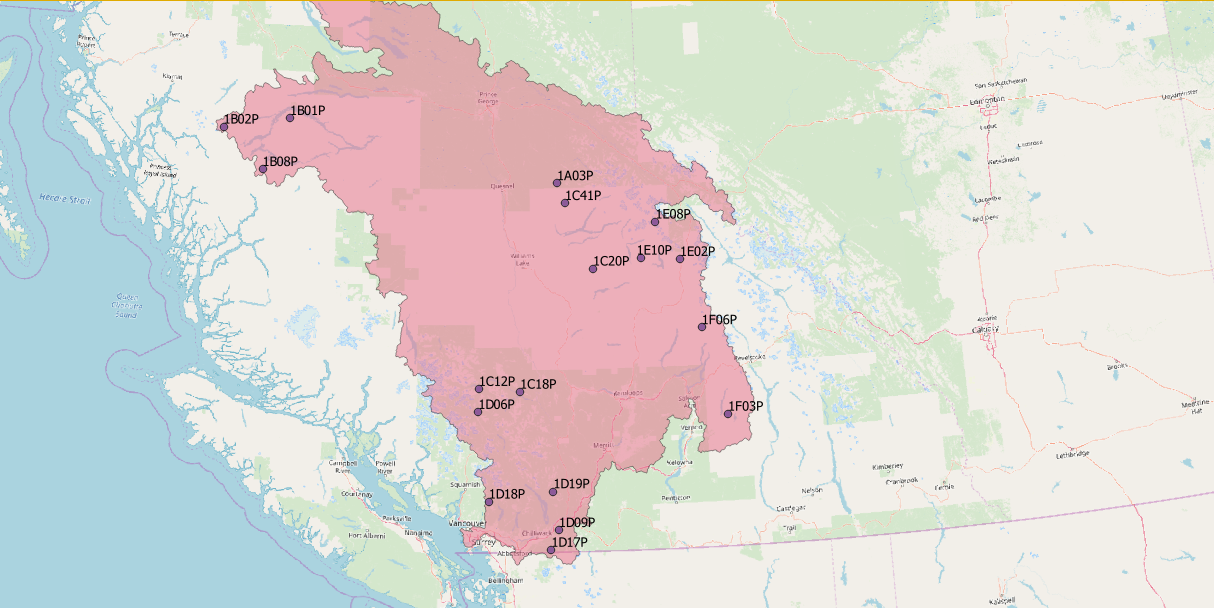

In [0]:
Image('availableStations.png')

In [0]:

snowData = pd.read_csv("maxSnowWater.csv") 
snowData.index = pd.to_datetime(snowData["Unnamed: 0"])
snowData.drop(["Unnamed: 0"], axis=1, inplace=True)

riverData = pd.read_csv("maxRiverDepths.csv") 
riverData.index = pd.to_datetime(riverData["Date"])
riverData.drop(["Date"], axis=1, inplace=True)

snowStations = ['1A03P', '1B01P', '1B02P','1C12P', '1C18P', '1C20P', '1C41P',
       '1D09P', '1D17P', '1D19P', '1E08P', '1E10P',
       '1F03P']

snowData = snowData[snowStations]
fullData = snowData.join(riverData)
fullDataTrain = fullData["2000-01-01":"2018-01-01"]
fullDataTest = fullData["2019-01-01":]

fullDataTest["Value"] = 8420.0


display(fullDataTrain)
display(fullDataTest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,1A03P,1B01P,1B02P,1C12P,1C18P,1C20P,1C41P,1D09P,1D17P,1D19P,1E08P,1E10P,1F03P,Value
Unnamed: 0,,,,,,,,,,,,,,
2000-12-31,341.0,438.0,1289.0,847.0,536.0,683.0,919.0,1486.0,1808.0,1845.0,1380.0,995.0,1223.0,8470.0
2001-12-31,278.0,521.0,1338.0,676.0,420.0,488.0,713.0,1033.0,1264.0,1166.0,833.0,732.0,709.0,7090.0
2002-12-31,443.0,798.0,1801.0,1158.0,689.0,731.0,1054.0,1453.0,2183.0,2175.0,1519.0,1081.0,1156.0,11000.0
2003-12-31,266.0,417.0,1198.0,1051.0,521.0,461.0,608.0,981.0,1361.0,1226.0,1013.0,728.0,899.0,7770.0
2004-12-31,234.0,390.0,933.0,661.0,375.0,334.0,736.0,1180.0,1571.0,1546.0,960.0,730.0,758.0,6810.0
2005-12-31,356.0,701.0,1332.0,747.0,402.0,544.0,851.0,780.0,881.0,600.0,1346.0,998.0,956.0,7560.0
2006-12-31,270.0,509.0,1268.0,951.0,512.0,533.0,716.0,1329.0,1770.0,1931.0,1174.0,797.0,960.0,8800.0
2007-12-31,443.0,957.0,2360.0,1387.0,904.0,701.0,1084.0,1173.0,2104.0,2318.0,1670.0,1028.0,1013.0,11800.0
2008-12-31,349.0,573.0,1332.0,856.0,508.0,784.0,1017.0,1497.0,1849.0,2007.0,1433.0,1054.0,1047.0,10900.0


,1A03P,1B01P,1B02P,1C12P,1C18P,1C20P,1C41P,1D09P,1D17P,1D19P,1E08P,1E10P,1F03P,Value
Unnamed: 0,,,,,,,,,,,,,,
2019-12-31,339.0,485.0,991.0,757.0,407.0,583.0,979.0,730.0,1353.0,1141.0,940.0,813.0,726.0,8420.0


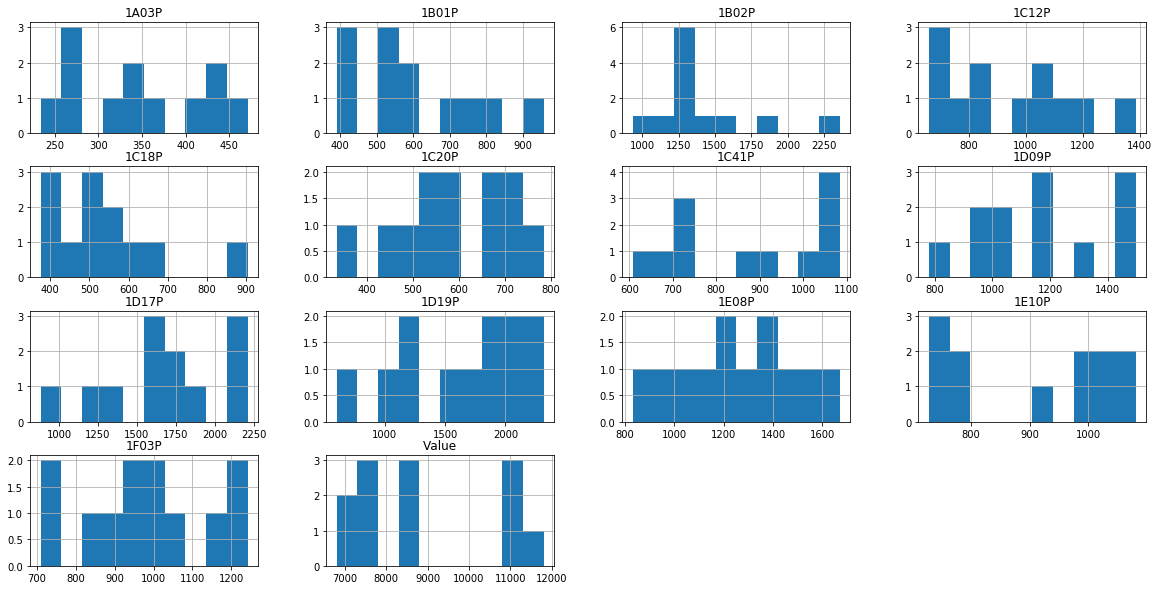

In [0]:
fullDataTrain.hist()
plt.show()

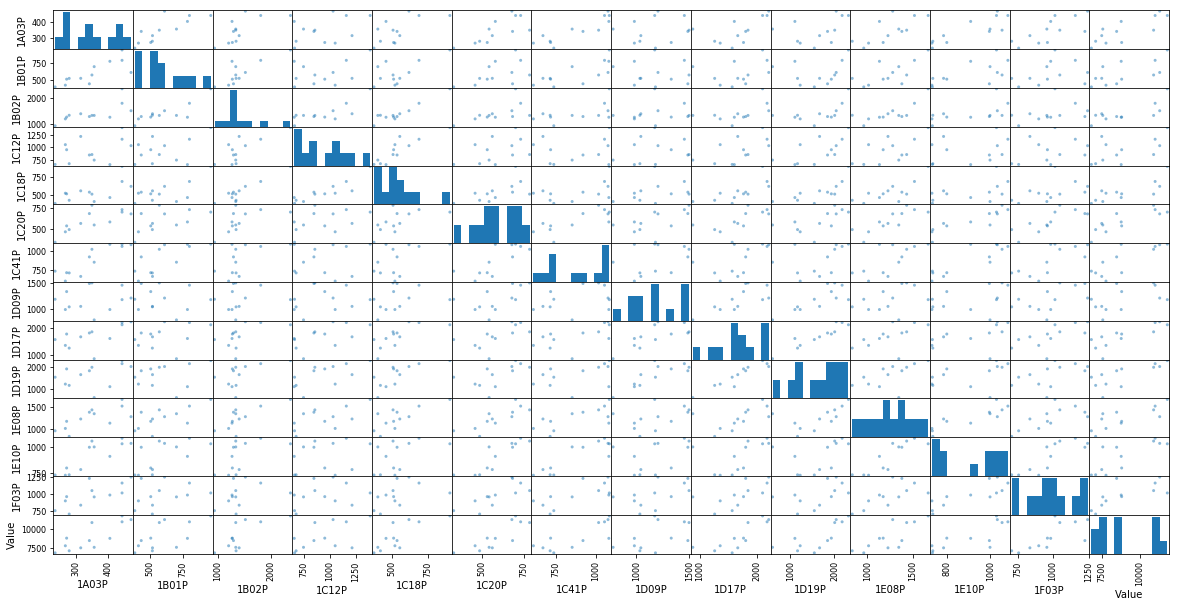

In [0]:
pd.plotting.scatter_matrix(fullDataTrain)
plt.show()

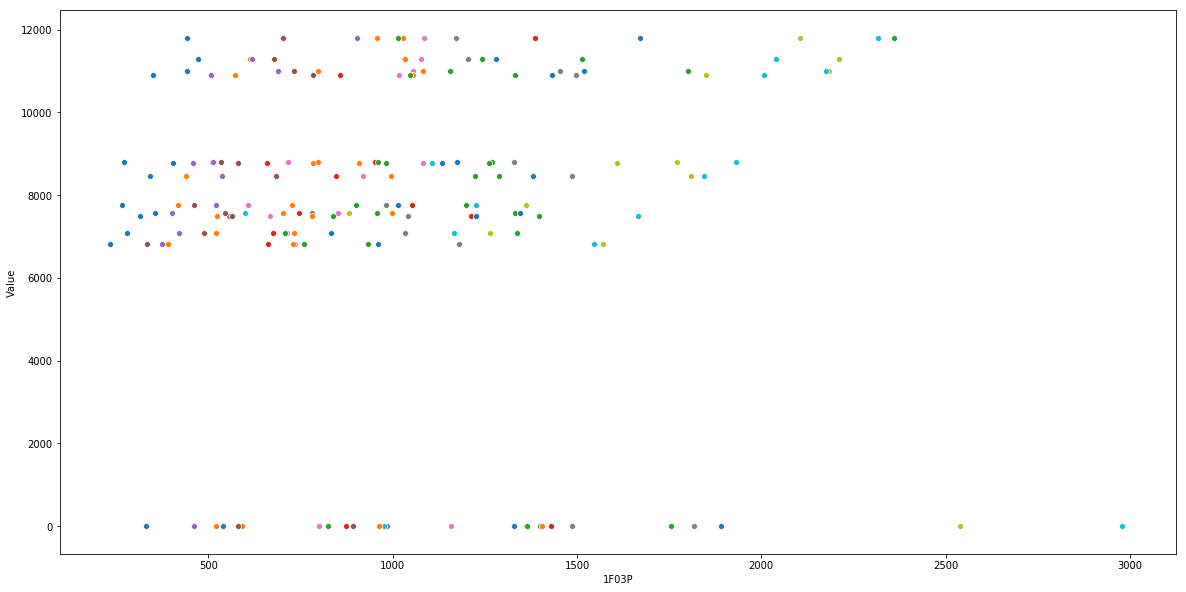

In [0]:
names = ['1A03P', '1B01P', '1B02P', '1C12P', '1C18P', '1C20P', '1C41P', '1D09P',
       '1D17P', '1D19P', '1E08P', '1E10P', '1F03P']

for column in names:
  sns.scatterplot(x=fullData[column], y=fullData["Value"])

plt.show()

In [0]:
corData = fullDataTrain.corr()

display(corData)

,1A03P,1B01P,1B02P,1C12P,1C18P,1C20P,1C41P,1D09P,1D17P,1D19P,1E08P,1E10P,1F03P,Value
1A03P,1.000000,0.797187,0.708524,0.428134,0.662386,0.762545,0.894093,0.159460,0.597015,0.399159,0.718784,0.845149,0.734360,0.816527
1B01P,0.797187,1.000000,0.817940,0.409106,0.654647,0.540462,0.736536,-0.086401,0.324478,0.212932,0.671088,0.639963,0.315309,0.650412
1B02P,0.708524,0.817940,1.000000,0.765282,0.934052,0.613230,0.561986,0.150528,0.538886,0.553068,0.752346,0.572567,0.361690,0.740381
1C12P,0.428134,0.409106,0.765282,1.000000,0.882706,0.444689,0.157081,0.196887,0.582651,0.645209,0.621840,0.284714,0.311324,0.573495
1C18P,0.662386,0.654647,0.934052,0.882706,1.000000,0.614968,0.513813,0.317399,0.723219,0.734803,0.751327,0.519638,0.474864,0.789069
1C20P,0.762545,0.540462,0.613230,0.444689,0.614968,1.000000,0.762000,0.571572,0.631442,0.593429,0.821923,0.879703,0.780154,0.840103
1C41P,0.894093,0.736536,0.561986,0.157081,0.513813,0.762000,1.000000,0.352387,0.602686,0.427150,0.690476,0.875708,0.711421,0.812533
1D09P,0.159460,-0.086401,0.150528,0.196887,0.317399,0.571572,0.352387,1.000000,0.724307,0.805648,0.419192,0.419723,0.545674,0.521788
1D17P,0.597015,0.324478,0.538886,0.582651,0.723219,0.631442,0.602686,0.724307,1.000000,0.936762,0.557291,0.506576,0.636741,0.807694
1D19P,0.399159,0.212932,0.553068,0.645209,0.734803,0.593429,0.427150,0.805648,0.936762,1.000000,0.579495,0.423551,0.512261,0.747011


,1A03P,1B01P,1B02P,1C12P,1C18P,1C20P,1C41P,1D09P,1D17P,1D19P,1E08P,1E10P,1F03P,Value
Value,0.816527,0.650412,0.740381,0.573495,0.789069,0.840103,0.812533,0.521788,0.807694,0.747011,0.779443,0.798424,0.719553,1.0


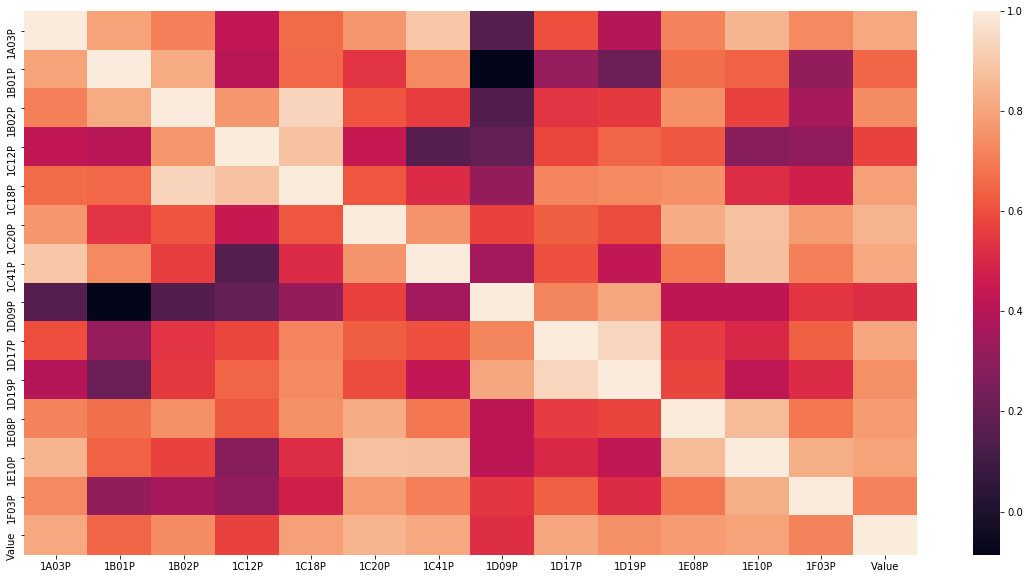

In [0]:
corData = fullDataTrain.corr()
valueCorr = corData.loc['Value']
display(valueCorr.to_frame().T)

sns.heatmap(corData)

**Linear Regression On All Features**

Initial Test with All features used for training, this will overfit data as features features # > samples #

In [0]:
trainCol = ['1A03P', '1B01P', '1B02P', '1C12P', '1C18P', '1C20P', '1C41P', '1D09P',
       '1D17P', '1D19P', '1E08P', '1E10P', '1F03P']

train_x = fullDataTrain[trainCol]
train_y = fullDataTrain['Value']
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)
pred1 = regr.predict(train_x)

print(regr.score(train_x, train_y))

pred = regr.predict(fullDataTest[trainCol])
print("Predicted: "+str(pred) + "  Actual"+str(fullDataTest['Value'].values))

1.0
Predicted: [11406.13216577]  Actual[8420.]


**Refined Test** 

Previous attempt broke rules of dimensonailty, due to the number of features being close to to the number of samples, it was grossly overfit. 

To combat this:

I Selected top 4 most correlated features or in this case snow data stations:

- 1A03P
-1C20P
-1C41P
-1D17P

From here remove the the least significant feature according to its P-Test until no features P Value > 0.05

 

In [0]:
trainCol = ['1A03P', '1C20P', '1C41P', '1D17P',]

train_x = fullDataTrain[trainCol]
train_y = fullDataTrain['Value']
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)
pred1 = regr.predict(train_x)

print(regr.score(train_x, train_y))

pred = regr.predict(fullDataTest[trainCol])
print("Predicted: "+str(pred) + "  Actual"+str(fullDataTest['Value'].values))

X2 = sm.add_constant(train_x)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

0.8754336521273762
Predicted: [8450.38463084]  Actual[8420.]
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     12.30
Date:                Fri, 05 Jul 2019   Prob (F-statistic):            0.00277
Time:                        16:15:20   Log-Likelihood:                -93.917
No. Observations:                  12   AIC:                             197.8
Df Residuals:                       7   BIC:                             200.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [0]:
trainCol = ['1A03P', '1C20P', '1D17P',]

train_x = fullDataTrain[trainCol]
train_y = fullDataTrain['Value']
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)
pred1 = regr.predict(train_x)

print(regr.score(train_x, train_y))

pred = regr.predict(fullDataTest[trainCol])
print("Predicted: "+str(pred) + "  Actual"+str(fullDataTest['Value'].values))

X2 = sm.add_constant(train_x)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

0.8715406665683018
Predicted: [8267.10582811]  Actual[8420.]
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     18.09
Date:                Fri, 05 Jul 2019   Prob (F-statistic):           0.000635
Time:                        16:53:22   Log-Likelihood:                -94.102
No. Observations:                  12   AIC:                             196.2
Df Residuals:                       8   BIC:                             198.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [0]:
trainCol = [ '1C20P', '1D17P',]

train_x = fullDataTrain[trainCol]
train_y = fullDataTrain['Value']
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)
pred1 = regr.predict(train_x)

print(regr.score(train_x, train_y))

pred = regr.predict(fullDataTest[trainCol])
print("Predicted: "+str(pred) + "  Actual"+str(fullDataTest['Value'].values))

X2 = sm.add_constant(train_x)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())

0.8335825793518199
Predicted: [8215.76388932]  Actual[8420.]
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     22.54
Date:                Fri, 05 Jul 2019   Prob (F-statistic):           0.000313
Time:                        16:54:17   Log-Likelihood:                -95.655
No. Observations:                  12   AIC:                             197.3
Df Residuals:                       9   BIC:                             198.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


**Model Selection**

Due to having the highest accuracy on the singualr test data set and it employing a larger range of snow stations I believe selecting the model with 4 including 4 snow stations data points will likely be the most accurtate. It embodies snow conditions for a large geographic region that feeds into the fraser river and will likely be more robust to differing snow conditions across the province.

Selected Stations from which to retrieve snow data are visible below on the map:

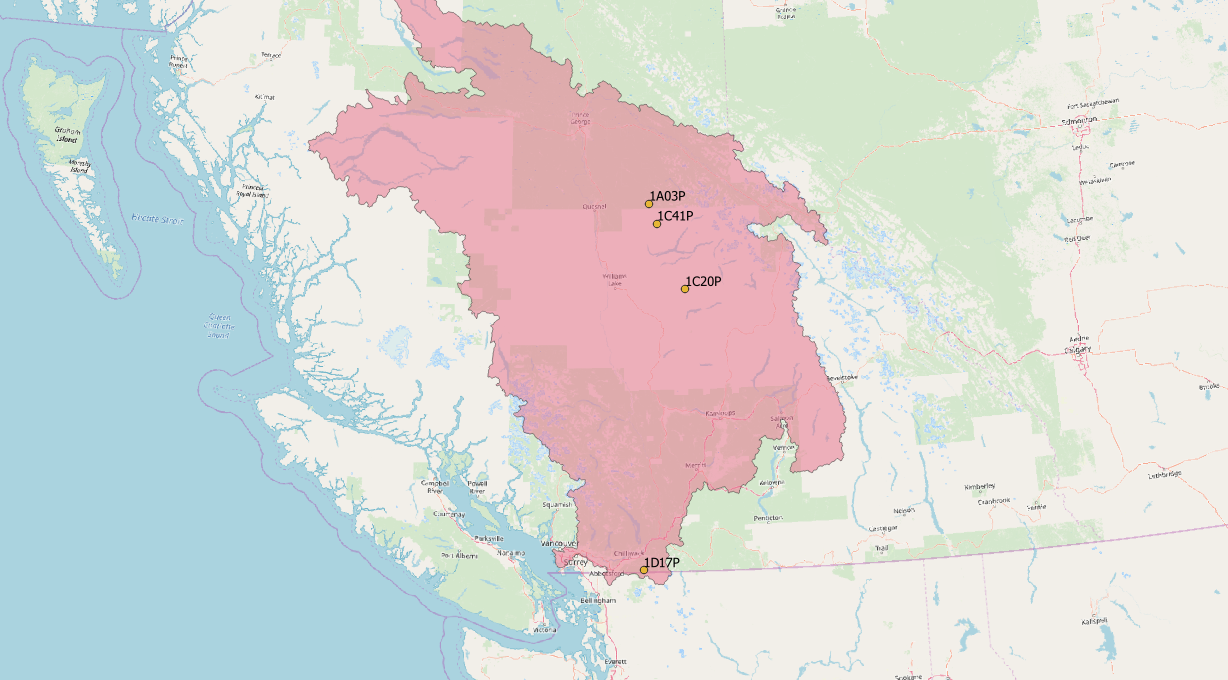

In [0]:
Image('selectedStations.png')

**Note results are somewhat inconclusive due to limitations on available data**

**Sanity Check**

Added next most correlated variable to linear regression to see affect on acccuracy, disregarding variable significance.

In [0]:
trainCol = ['1A03P', '1C20P', '1C41P', '1D17P', "1E10P"]

train_x = fullDataTrain[trainCol]
train_y = fullDataTrain['Value']
regr = linear_model.LinearRegression()

regr.fit(train_x, train_y)
pred1 = regr.predict(train_x)

print(regr.score(train_x, train_y))

pred = regr.predict(fullDataTest[trainCol])
print("Predicted: "+str(pred) + "  Actual"+str(fullDataTest['Value'].values))

X2 = sm.add_constant(train_x)
est = sm.OLS(train_y, X2)
est2 = est.fit()
print(est2.summary())


0.8771728656758344
Predicted: [8209.2897107]  Actual[8420.]
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     8.570
Date:                Fri, 05 Jul 2019   Prob (F-statistic):             0.0105
Time:                        16:15:24   Log-Likelihood:                -93.833
No. Observations:                  12   AIC:                             199.7
Df Residuals:                       6   BIC:                             202.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


**Note** accuracy on test decreases as model likely begins to over fit data, however we use this as a benchmark position to compare the 4 variable Linear regression model against.



In [0]:
!jupyter nbconvert --to html notebook.ipynb

[NbConvertApp] WARNING | pattern u'notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run nbco